In [1]:
# importa os pacotes necessários
import numpy as np
import os, cv2, random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import os
%matplotlib inline 

# Lendo imagem

(32, 32, 3)


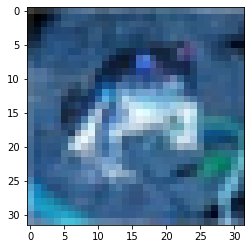

In [2]:
#funções de leitura das imagens
def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR) #cv2.IMREAD_GRAYSCALE
    return img#cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)
img = read_image('kaggle/train/1.png')
print(img.shape)
plt.imshow(img)

# Descritor 1 - Histograma

((512,), (512,))

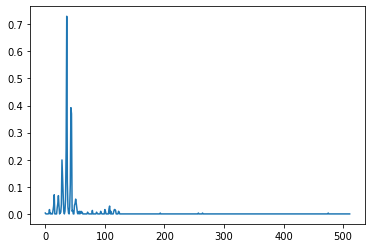

In [3]:
def extract_color_histogram(image, bins=(8, 8, 8)):     
    # extract a 3D color histogram from the HSV color space using
    # the supplied number of `bins` per channel
    #image = cv2.imread(image_file)        
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0, 1, 2], None, bins,
                        [0, 180, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    # the flattened histogram as the feature vector
    hist = hist.flatten()
    
    #columns name
    columns = np.array(['hist_%03d'%(i+1) for i in range(len(hist))])
    
    return hist, columns
hist, cols1 = extract_color_histogram(img)
plt.plot(hist)
hist.shape, cols1.shape

# Descritor 2 - Feature Vector

((3072,), (3072,))

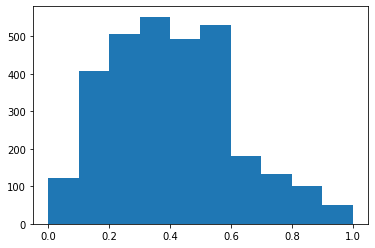

In [4]:
def image_to_feature_vector(image, size=(32, 32)):
    # resize the image to a fixed size, then flatten the image into
    # a list of raw pixel intensities
    if img.shape[:2] != size:
        fvet = cv2.resize(image, size).flatten()
    else:
        fvet = image.flatten()
    fvet = fvet/255
    
    #columns name
    columns = np.array(['fvet_%03d'%(i+1) for i in range(len(fvet))])
    
    return fvet,columns

fvet, cols2 = image_to_feature_vector(img)
plt.hist(fvet)
fvet.shape, cols2.shape

# Descritor 3 - Hu Moments

In [5]:
def hu_moments(image, size=(32, 32)):
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    hmom = cv2.HuMoments(cv2.moments(img_gray)).flatten()
    cols = np.array(['humom_1','humom_2','humom_3','humom_4','humom_5','humom_6','humom_7'])
    return hmom,cols
hmom, cols3 = hu_moments(img)
print(hmom)
hmom.shape, cols3.shape

[ 1.37597983e-03  8.55818987e-09  1.99613546e-11  5.12474924e-12
  4.67974848e-23 -2.65526534e-16  2.22850951e-23]


((7,), (7,))

Ver depois 
http://wiki.icmc.usp.br/images/d/d7/Dip10_imagedescription-texture.pdf

# Junta Descritores

In [6]:
#Cria uma serie com descritores
def junta_descritores(descritores, colunas):
    serie = pd.Series()
    for d,c in zip(descritores, colunas):
        serie = serie.append(pd.Series(d, index=c))
    return serie

In [7]:
serie = junta_descritores([hist,fvet,hmom],[cols1,cols2,cols3])
print(serie.shape)
print(serie.head(3))
print(serie.tail(3))

(3591,)
hist_001    0.003214
hist_002    0.000000
hist_003    0.000000
dtype: float64
humom_5    4.679748e-23
humom_6   -2.655265e-16
humom_7    2.228510e-23
dtype: float64


# Pipeline

In [8]:
# retorna uma serie com os descritores
def pipeline1(file_path):
    
    img = read_image(file_path)
    
    #descritores
    hist, cols1 = extract_color_histogram(img)
    fvet, cols2 = image_to_feature_vector(img,size=(16, 16))
    hmom, cols3 = hu_moments(img)
    #...
    
    #junta
    serie = junta_descritores([hist,fvet,hmom],[cols1,cols2,cols3])
    
    return serie

In [9]:
def run_pipeline(n_images = 50000, folder = 'train'): 
    
    lista_series = list()
    df = pd.DataFrame()
    
    #para cada imagem 
    for i in range(n_images):
        if (i+1)%1000 == 0:
            print(i+1,'/',n_images)
            df = df.append(lista_series)
            lista_series = list()
            
        #adiciona linha na tabela
        file_path = os.path.join(os.path.join('kaggle',folder),str(i+1))+'.png'
        serie = pipeline1(file_path)
        lista_series.append(serie)
    
    if len(lista_series):
        df = df.append(lista_series)
    df = df.reset_index(drop = True).astype('float32')
    
    #PCA
    print("PCA ...")
    n_componentes = int(df.shape[1]/2)
    pca = PCA(n_components=n_componentes)
    principalComponents = pca.fit_transform(df)
    df_pca = pd.DataFrame(data = principalComponents,
                          columns = ['comp_%03d'%i for i in range(n_componentes)]).astype('float32')
    
    #salva
    print('Salvando ...')
    file_path = os.path.join('kaggle',folder)+'.csv'
    df.to_csv(file_path)
    file_path = os.path.join('kaggle',folder+'_pca')+'.csv'
    df_pca.to_csv(file_path)
    
    print('End')
    return df,df_pca

In [10]:
%%time
df,df_pca = run_pipeline()

1000 / 50000
2000 / 50000
3000 / 50000
4000 / 50000
5000 / 50000
6000 / 50000
7000 / 50000
8000 / 50000
9000 / 50000
10000 / 50000
11000 / 50000
12000 / 50000
13000 / 50000
14000 / 50000
15000 / 50000
16000 / 50000
17000 / 50000
18000 / 50000
19000 / 50000
20000 / 50000
21000 / 50000
22000 / 50000
23000 / 50000
24000 / 50000
25000 / 50000
26000 / 50000
27000 / 50000
28000 / 50000
29000 / 50000
30000 / 50000
31000 / 50000
32000 / 50000
33000 / 50000
34000 / 50000
35000 / 50000
36000 / 50000
37000 / 50000
38000 / 50000
39000 / 50000
40000 / 50000
41000 / 50000
42000 / 50000
43000 / 50000
44000 / 50000
45000 / 50000
46000 / 50000
47000 / 50000
48000 / 50000
49000 / 50000
50000 / 50000
PCA ...
Salvando ...
End
CPU times: user 6min 36s, sys: 32.1 s, total: 7min 8s
Wall time: 5min 45s


In [11]:
print(df.shape)
df.head()

(50000, 1287)


,hist_001,hist_002,hist_003,hist_004,hist_005,hist_006,hist_007,hist_008,hist_009,hist_010,...,fvet_766,fvet_767,fvet_768,humom_1,humom_2,humom_3,humom_4,humom_5,humom_6,humom_7
0,0.003214,0.000000,0.000000,0.000000,0.000000,0.000000,0.003214,0.016068,0.000000,0.003214,...,0.219608,0.317647,0.447059,0.001376,8.558190e-09,1.996135e-11,5.124749e-12,4.679749e-23,-2.655265e-16,2.228509e-23
1,0.007545,0.007545,0.022635,0.075451,0.022635,0.045270,0.098086,0.120721,0.000000,0.015090,...,0.525490,0.494118,0.529412,0.001152,2.020843e-09,3.868780e-11,6.433244e-12,-4.678342e-23,-2.786453e-16,9.006636e-23
2,0.000000,0.000000,0.026750,0.015286,0.000000,0.011464,0.042036,0.703141,0.003821,0.022929,...,0.317647,0.325490,0.301961,0.001243,9.735721e-09,1.120396e-10,1.157212e-10,7.807502e-21,-1.138781e-14,1.061447e-20
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.184314,0.262745,0.286275,0.001713,6.692215e-09,8.255245e-12,2.703786e-12,1.031088e-23,-3.207973e-17,7.540437e-24
4,0.011915,0.011915,0.202553,0.047660,0.029787,0.029787,0.053617,0.131064,0.005957,0.059574,...,0.309804,0.298039,0.282353,0.001608,3.536035e-08,6.717288e-11,1.433193e-11,-2.684715e-22,-2.592121e-15,3.544983e-22


In [12]:
print(df_pca.shape)
df_pca.head()

(50000, 643)


,comp_000,comp_001,comp_002,comp_003,comp_004,comp_005,comp_006,comp_007,comp_008,comp_009,...,comp_633,comp_634,comp_635,comp_636,comp_637,comp_638,comp_639,comp_640,comp_641,comp_642
0,-3.197883,1.380269,0.740793,2.321128,1.381360,0.292483,-0.320347,0.191727,-1.637414,0.573441,...,-0.024792,0.045877,0.027880,-0.001795,0.046510,0.005527,0.037153,-0.061800,0.017775,-0.035746
1,0.432418,-0.474380,2.985762,-0.372687,0.948086,0.585216,-0.342111,-0.177264,-1.299614,1.279630,...,0.020965,-0.017500,0.004794,0.031049,0.011890,-0.021927,-0.031323,0.004768,-0.007784,0.000758
2,3.866369,-5.751267,-1.397672,-0.701589,1.225061,-1.105348,0.325142,-0.697994,0.270915,-0.565156,...,-0.008438,-0.022661,0.000723,-0.013556,0.002779,0.004803,-0.003301,0.006846,-0.016662,0.022950
3,-5.177614,0.011442,0.538458,0.953614,0.441988,0.423874,-0.134181,0.168956,-0.718973,-0.185578,...,-0.015079,-0.013434,0.017569,0.005277,-0.002907,0.010175,-0.007885,0.006420,0.014084,0.004552
4,-1.302909,-2.489516,0.526420,-1.786733,0.113426,-0.108457,-2.791657,0.842451,-1.858618,-0.962530,...,0.012354,-0.032186,-0.012811,-0.014408,0.012763,0.015072,0.055825,-0.007483,-0.000350,0.001611
